<a href="https://colab.research.google.com/github/silvacaio/challange_clusters/blob/master/Challenge_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Você foi contratado por uma empresa de jogos para classificar seus jogadores em algum número de categorias de forma que eles possam organizar as partidas apenas dentro desses níveis. O objetivo principal é que as partidas sejam equilibradas - jogadores consigam partidas com jogadores de um nível de habilidade similar.
Além disso, a empresa gostaria de saber se os jogadores de algum país se destacam mais no jogo.

Você precisará extrair informações de

1. API Players : Informações pessoais dos jogadores - id, nome, e-mail, país e último login

2. PostgreSQL Matches table: Informações sobre as partidas realizadas - id, tipo de partida, jogadores participantes, data e duração

3. PostgreSQL Goals table: Informações sobre os gols feitos em cada partida - id, tempo de partida em que o gol ocorreu e jogador que fez o gol

Endereço da API
https://api.desafio.online

Credenciais do banco PostgreSQL

Usuário: readonly

Senha: desafiodsop

Host: rds.desafio.online

Banco: iclinic_games

Porta: 5432


Apresente os grupos que formar de acordo com seu método separando os nomes dos jogadores em cada categoria.
Utilize técnicas estatísticas de clusterização para justificar a resposta e apresente todos os scripts utilizados, além da argumentação em texto que julgar necessária.
Junte todos os arquivos relevantes para a sua resposta em um arquivo ZIP ou RAR, poste em algum serviço online e disponibilize o link aqui na resposta.

#Packages

In [ ]:
import pandas as pd
import numpy as np
import json
import requests

# 1 - Buscar informações dos jogadores na API

In [ ]:
response = requests.get("https://api.desafio.online/v1/players/")

In [ ]:
players =  response.json()['body']

In [ ]:
len(players)

200

# 2 - Parametrizando a conexão com o banco de dados

In [ ]:
!pip install sqlalchemy psycopg2
!conda install -y sqlalchemy psycopg2

/bin/bash: conda: command not found


In [ ]:
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
POSTGRES_ADDRESS = 'rds.desafio.online' # endereço do banco da dos
POSTGRES_PORT = '5432' # porta utilizada
POSTGRES_USERNAME = 'readonly' # usuário
POSTGRES_PASSWORD = "desafiodsop" # senha
POSTGRES_DBNAME = 'iclinic_games' # nome da DB

# connectionString formatada
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# 3 - Conhecendo as tabelas disponíveis

In [ ]:
matches = pd.read_sql_query('''SELECT * FROM Matches limit 1;''', cnx)
matches.head()

,match_id,match_type,player_1,player_2,match_date,match_duration
0,M02109295,Ranked,DA1X9864,IA8T7256,2019-05-20,00:10:00


In [ ]:
goals = pd.read_sql_query('''SELECT * FROM Goals limit 1;''', cnx)
goals.head()

,goal_id,match_id,goal_timestamp,player_id
0,1,M02178449,00:09:48,SV4W8695


# 4 - Proposta de solução:



1.  Fazer um join entre as tabelas de Matches e Goals, agruprando por match_id e match_type, podendo assim ter uma visão geral do jogo. 

2.   Gerar uma nova coleção relacionando os dados dos jogadores com as partidas por estes realizadas, podendo assim obter as informações individuais de cada jogador.

1.   Verificar os dados e realizar a limpeza (se necesario)

1.   Foi identificado que existem dois tipos de jogos (match_type). Será feito analise individual para cada tipo, a fim de se encontrar clusters de jogadores dentro de cada um destes tipos.

1.   Gerar clusters para cada um dos tipos de partida (match_type), para isso deverá ter duas coleções (uma para cada match_type

1.   Para o processo de clusterização será utilizado a propriedade quantidade de partidas e a média de vitórias por jogo. Dessa maneira é possível nivelar os jogadores em categorias por meio de suas similaridades.

2.   Padronizar os valores númericos (sklearn MinMaxScaler)

6.   Aplicar o Método Elbow para descobrir o número de clusters de cada um dos tipos de jogo

2.   Geração de Clusters

8.   Apresentação dos resultados













# Busca informações do banco de dados

In [ ]:
# sql que realiza o join das tabelas
query = """SELECT
  match.match_id,
  match.match_type,
  max(match.player_1) player_1,
  SUM(
    CASE WHEN goal.player_id = match.player_1 THEN 1 ELSE 0 END
  ) score_player_1,
  max(match.player_2) player_2,
  SUM(
    CASE WHEN goal.player_id = match.player_2 THEN 1 ELSE 0 END
  ) score_player_2
FROM
  Matches as match
  INNER JOIN Goals as goal on match.match_id = goal.match_id
GROUP BY
  match.match_id,
  match.match_type;"""

# realiza a consulta
result = pd.read_sql_query(query, cnx)

In [ ]:
# estatistica descritiva
result.describe()

,score_player_1,score_player_2
count,99495.000000,99495.000000
mean,5.288065,0.000653
std,2.264055,0.064891
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,7.000000,0.000000
max,18.000000,9.000000


In [ ]:
# Verificando registros nulos:
result.isnull().sum()

match_id          0
match_type        0
player_1          0
score_player_1    0
player_2          0
score_player_2    0
dtype: int64

In [ ]:
# pega todos os tipos de jogos possíves
types_game = result.match_type.unique()
types_game

array(['Ranked', 'Casual'], dtype=object)

# Metódos utilizados para processamento dos dados

In [ ]:
# metodo para gerar as informações de cada um jogos jogadores, para cada tipo de jogo (Ranked, Casual)
positions_player = {'player_1': ("score_player_1", "score_player_2"),'player_2': ("score_player_2", "score_player_1") }
def get_data_player_by_game_type(player_id, position_player, game_type):

  score_player = positions_player[position_player][0] # coluna que tem o score do jogador
  score_opponent = positions_player[position_player][1] # coluna que tem o score do adversario

  # dados do jogador para determinado tipo de jogo
  data = result[(result[position_player] == player_id) & (result.match_type == game_type)]
  # quantidade de vitorias
  win = len(data[data[score_player] > data[score_opponent]])
  # quantidade de derrotas
  lost = len(data[data[score_player] < data[score_opponent]])
  # quantidade de empates
  draw = len(data[data[score_player] == data[score_opponent]])  
  # total de gols pró
  total_score = data[score_player].sum()
  # total de gols sofridos
  total_score_conceded = data[score_opponent].sum()

  return win, lost, draw, total_score, total_score_conceded


In [ ]:
def create_frame(data):
  # colunas do novo data frame
  columns = ["name", "country", "win", "lost", "draw", "games", "total_score", "total_score_conceded"]
  # novo data frame
  df = pd.DataFrame(data, columns=columns)

  return df

In [ ]:
from sklearn import preprocessing

# sumarizando os dados com o sklearn MinMaxScaler
def scaler_data(data, features):
  scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
  data[features] = scaler.fit_transform(data[features])

In [ ]:
#features que serão utilizados no processo de cluster
features_clusterization = ['win', 'lost','draw','games','total_score','total_score_conceded']

In [ ]:
import random

def get_colors():
  number_of_colors = 8

  color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

  return color

# Criação do data set de cada um dos tipos de jogos

In [ ]:
# dicionario com os dados dos jogadores em cada um dos tipos de jogos
data_players_by_game = dict()

for game_type in types_game:
  data_players_by_game[game_type] = []

for player in players:  
  name = player["player_name"] # nome do jogador
  country = player["country"] # país do jogador
  id = player["player_id"] # id do jogador

  for game_type in types_game:
    #informações quando o jogador é player_1
    player_1 = get_data_player_by_game_type(id, "player_1", game_type)
    #informações quando o jogador é player_2
    player_2 = get_data_player_by_game_type(id, "player_2", game_type)

    win = player_1[0] + player_2[0] # soma vitorias    
    lost = player_1[1] + player_2[1] # soma derrotas    
    draw = player_1[2] + player_2[2] # soma empates
    total_score = player_1[3] + player_2[3] # soma total de gols feitos
    total_score_conceded = player_1[4] + player_2[4] # soma total de gols sofridos 
    
    # adiciona uma tupla com os valores do jogador no dicionario
    data_players_by_game[game_type].append((name, country, win, lost, draw, win + lost + draw, total_score, total_score_conceded))

# Clusters para jogos Casuais

In [ ]:
df_games_casual = create_frame(data_players_by_game[types_game[1]])

#estatistica descritiva
df_games_casual.describe()

,win,lost,draw,games,total_score,total_score_conceded
count,200.000000,200.000000,200.0,200.000000,200.000000,200.000000
mean,5.430000,5.210000,0.0,10.640000,29.210000,27.680000
std,2.302522,2.271939,0.0,3.215915,13.728374,12.623564
min,0.000000,1.000000,0.0,2.000000,0.000000,3.000000
25%,4.000000,3.750000,0.0,8.000000,19.000000,18.000000
50%,5.000000,5.000000,0.0,11.000000,28.000000,27.000000
75%,7.000000,7.000000,0.0,13.000000,37.000000,37.250000
max,12.000000,11.000000,0.0,20.000000,76.000000,60.000000


In [ ]:
# copia para um data frame que será usado para clusterização
df_games_casual_standardized = df_games_casual.copy()

In [ ]:

df_games_casual_standardized["win_mean"] = df_games_casual_standardized.win / df_games_casual_standardized.games

In [ ]:
scaler_data(df_games_casual_standardized, features_clusterization)

In [ ]:
data_to_cluster_casual =  df_games_casual_standardized[['win_mean','games']].iloc[: , :].values

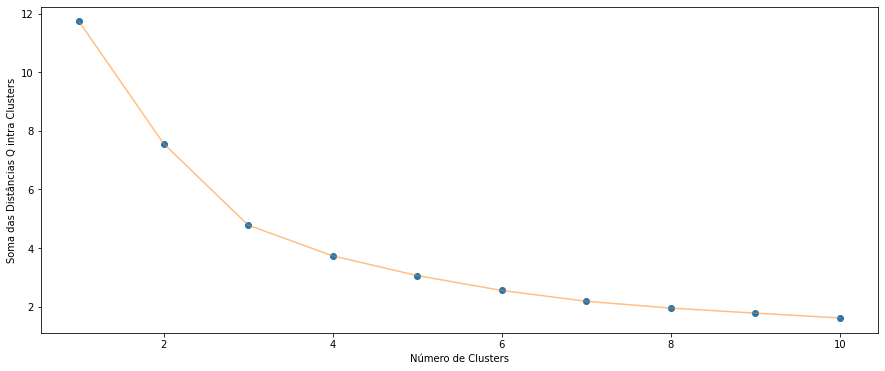

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# calcula a inertia, para saber o K ótimo
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(data_to_cluster_casual)
    inertia.append(algorithm.inertia_)

# plot da inercia
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

In [ ]:
#estabilização da curva 
inertia

[11.735051660926459,
 7.568847609012948,
 4.785473316465768,
 3.73583315336967,
 3.0614131985022297,
 2.5533221997822952,
 2.184299922232546,
 1.9514622697245896,
 1.779569696988828,
 1.614262241000955]

In [ ]:
# Inicializando e Computando o KMeans com o valor de 3 clusters:
algorithm = (KMeans(n_clusters =3 ))
algorithm.fit(data_to_cluster_casual)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# adiciona uma coluna com a categoria de cada jogador
df_games_casual["categorie"] = algorithm.labels_

# RESULTADO JOGOS CASUAIS:

Para os jogos casuais os jogadores foram dividos em 3 categorias.
Onde cada categoria conta com:

Categoria 1    82

Categoria 0    61

Categoria 2    57

A planilha "casual.csv" contém o nome dos jogadores e suas respectivas categorias.

Países com maior número de vitórias:

1 - Myanmar

2 - Spain

3 - Equatorial Guinea

4 - Togo

5 - Marshall Islands

Text(0.5, 1.0, 'Dados por categoria')

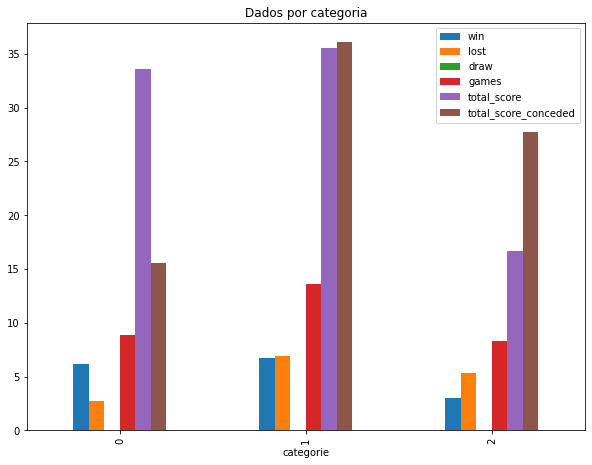

In [ ]:
df_games_casual.groupby("categorie").aggregate("mean").plot.bar(figsize=(10,7.5))
plt.title("Dados por categoria")

In [ ]:
df_games_casual.categorie.value_counts()

1    82
2    61
0    57
Name: categorie, dtype: int64

In [ ]:
df_games_casual.to_csv("casual.csv", sep=";")

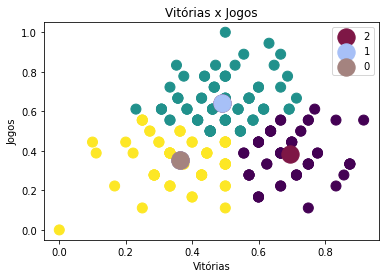

In [ ]:
color = get_colors()

plt.scatter(data_to_cluster_casual[:, 0], data_to_cluster_casual[:,1], s = 100, c = algorithm.labels_)
for centroid in range(len(algorithm.cluster_centers_)):  
  plt.scatter(algorithm.cluster_centers_[centroid:, 0], algorithm.cluster_centers_[centroid:, 1], s = 300, c = color[centroid],label = str(algorithm.labels_[centroid]))

plt.title('Vitórias x Jogos')
plt.xlabel('Vitórias')
plt.ylabel('Jogos')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Vitórias por país')

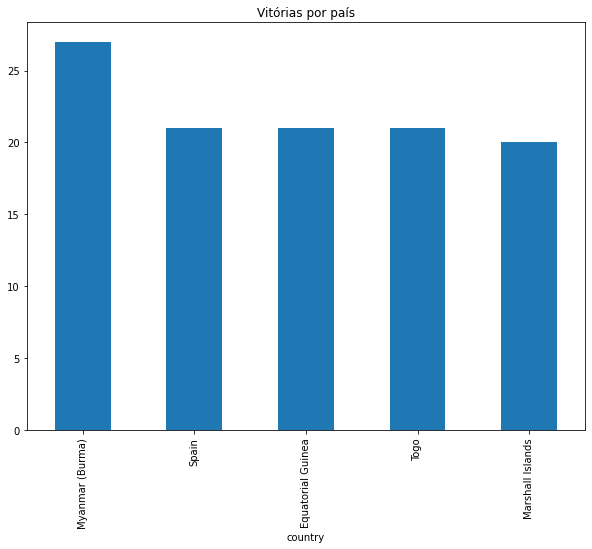

In [ ]:
df_games_casual.groupby("country").aggregate("sum").sort_values(by='win', ascending=False) \
.head(5).win.plot.bar(figsize=(10,7.5) )
plt.title("Vitórias por país")

# Clusters para jogos Rankeados

In [ ]:
df_games_ranked = create_frame(data_players_by_game[types_game[0]])

#estatistica descritiva
df_games_ranked.describe()

,win,lost,draw,games,total_score,total_score_conceded
count,200.000000,200.000000,200.0,200.00000,200.000000,200.000000
mean,5.415000,4.825000,0.0,10.24000,29.415000,25.825000
std,2.237815,2.181322,0.0,3.25351,12.907587,12.769089
min,1.000000,0.000000,0.0,3.00000,5.000000,0.000000
25%,4.000000,3.000000,0.0,8.00000,19.750000,16.750000
50%,5.000000,4.500000,0.0,10.00000,28.500000,25.000000
75%,7.000000,6.000000,0.0,12.00000,38.250000,34.250000
max,12.000000,11.000000,0.0,20.00000,78.000000,58.000000


In [ ]:
# copia para um data frame que será usado para clusterização
df_games_ranked_standardized = df_games_ranked.copy()

In [ ]:
# calculma a media
df_games_ranked_standardized["win_mean"] = df_games_ranked_standardized.win / df_games_ranked_standardized.games

In [ ]:
scaler_data(df_games_ranked_standardized, features_clusterization)

In [ ]:
# pega os dados que serão utilizados no processo de clusterização
data_to_cluster_ranked = df_games_ranked_standardized[['win_mean','games']].iloc[: , :].values

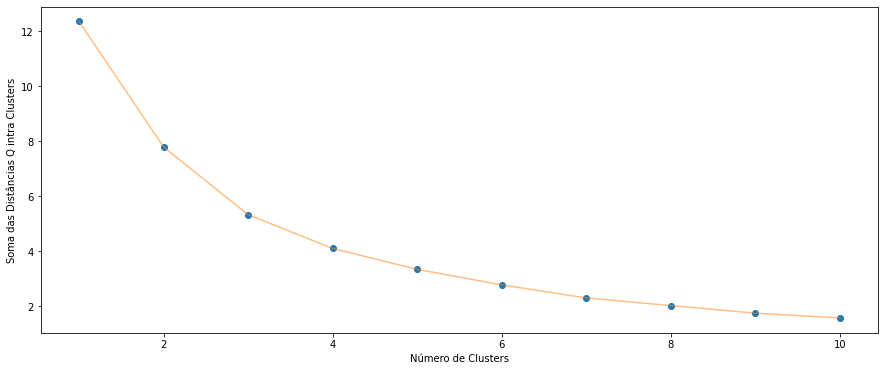

In [ ]:
# calcula a inertia, para saber o K ótimo
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(data_to_cluster_ranked)
    inertia.append(algorithm.inertia_)

# plot da inercia

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

In [ ]:
inertia

[12.344312901778938,
 7.79144576119466,
 5.331812170817765,
 4.105702829461924,
 3.3461828220672145,
 2.782593474576871,
 2.3090015495726783,
 2.030587954712293,
 1.7561119064611823,
 1.5812826679328063]

In [ ]:
# Inicializando e Computando o KMeans com o valor de 4 clusters:
algorithm = (KMeans(n_clusters = 3))
algorithm.fit(data_to_cluster_ranked)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
df_games_ranked["categorie"] = algorithm.labels_

# RESULTADO JOGOS RANKEADOS:

Para os jogos rankeados os jogadores foram dividos em 3 categorias.
Onde cada categoria conta com:

Categoria 1    73

Categoria 0    64

Categoria 2    63

A planilha "ranked.csv" contém o nome dos jogadores e suas respectivas categorias.

Países com maior número de vitórias:

1 - Togo

2 - Equatorial Guinea

3 - Myanmar

4 - Guyana

5 - Benin

In [ ]:
df_games_ranked.categorie.value_counts()

2    73
0    64
1    63
Name: categorie, dtype: int64

Text(0.5, 1.0, 'Dados por categoria')

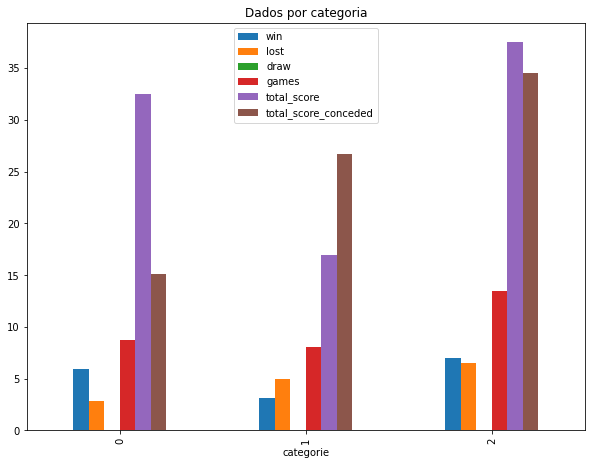

In [ ]:
df_games_ranked.groupby("categorie").aggregate("mean").plot.bar(figsize=(10,7.5))
plt.title("Dados por categoria")

In [ ]:
df_games_ranked.to_csv("ranked.csv", sep=";")

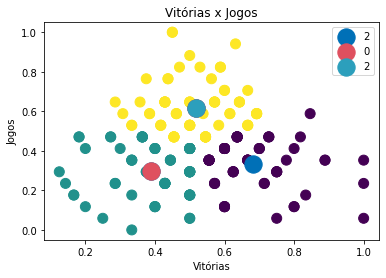

In [ ]:
color = get_colors()

plt.scatter(data_to_cluster_ranked[:, 0], data_to_cluster_ranked[:,1], s = 100, c = algorithm.labels_)
for centroid in range(len(algorithm.cluster_centers_)):  
  plt.scatter(algorithm.cluster_centers_[centroid:, 0], algorithm.cluster_centers_[centroid:, 1], s = 300, c = color[centroid],label = str(algorithm.labels_[centroid]))

plt.title('Vitórias x Jogos')
plt.xlabel('Vitórias')
plt.ylabel('Jogos')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Vitórias por país')

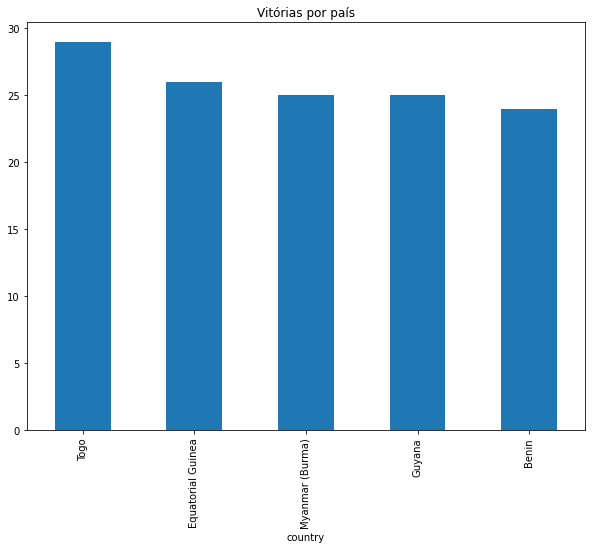

In [ ]:
df_games_ranked.groupby("country").aggregate("sum").sort_values(by='win', ascending=False) \
.head(5).win.plot.bar(figsize=(10,7.5) )
plt.title("Vitórias por país")